# Install

In [ ]:
! pip install konlpy

# 라이브러리

In [14]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from konlpy.tag import Okt
import gensim
from gensim.models import Word2Vec, FastText
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 데이터 수집

In [ ]:
# 수집 사이트 및 HTTP 호출 정보
product_url = "https://display.musinsa.com/display/api/v2/categories/ITEM/goods"

review_url = "https://goods.musinsa.com/api/goods/v2/review-list-html"
header = {
    "referer" : "https://www.musinsa.com/",
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
}

In [ ]:
class ReviewCrawler:
    def __init__(self, product_url, review_url, header):
        """
        ReviewCrawler 클래스 초기화 함수입니다.

        Args:
        - product_url (str): 상품 정보를 가져올 URL
        - review_url (str): 리뷰 정보를 가져올 URL
        - header (dict): HTTP 요청 시 사용할 헤더 정보
        """
        self.product_url = product_url
        self.review_url = review_url
        self.header = header

    def cate_crawling(self, cate, page):
        """
        카테고리 별 상품 정보를 가져오는 메서드입니다.

        Args:
        - cate (str): 가져올 상품 카테고리 코드
        - page (int): 가져올 페이지 번호

        Returns:
        - pd.DataFrame: 상품 정보가 담긴 DataFrame
        """
        product_params = {
            "siteKindId": "musinsa",
            "sex": "M",
            "sortCode": "1y",
            "categoryCode": cate,
            "size": "100",
            "page": page
        }

        # 상품 정보 요청
        response = requests.get(self.product_url, params=product_params)

        # 요청 성공 여부 출력
        if response.status_code == 200:
            print(f"{cate} 카테고리 상품정보 가져오기 성공")
        else:
            print(f"{cate} 카테고리 상품정보 가져오기 실패")

        # JSON 형식으로 변환하여 DataFrame 생성
        data = response.json()
        product_df = pd.DataFrame(data["data"]["goodsList"])
        new_df = product_df[["goodsNo", "brandName", "brandNameEng", "goodsName", "imageUrl",
                             "relatedGoodsReviewScore"]]
        return new_df

    def fetch_reviews(self, goods_no, page_num):
        """
        상품 리뷰를 가져오는 메서드입니다.

        Args:
        - goods_no (int): 상품 번호
        - page_num (int): 가져올 리뷰 페이지 번호

        Returns:
        - BeautifulSoup: 리뷰 페이지의 BeautifulSoup 객체
        """
        review_params = {
            "goodsNo": str(goods_no),
            "sex": "",
            "myFilter": "false",
            "type": "goods",
            "bodyFilterAvailable": "Y",
            "similarNo": "0",
            "selectedSimilarNo": str(goods_no),
            "selectedSimilarName": "",
            "minHeight": "0",
            "maxHeight": "0",
            "minWeight": "0",
            "maxWeight": "0",
            "minHeightList": "",
            "maxHeightList": "",
            "minWeightList": "",
            "maxWeightList": "",
            "skinType": "",
            "skinTone": "",
            "skinWorry": "",
            "reviewSex": "W",
            "optionCnt": "1",
            "option1": "",
            "option2": "",
            "option1List": "",
            "option2List": "",
            "keyword": "",
            "page": str(page_num),
            "sort": "up_cnt_desc"
        }

        # 리뷰 정보 요청
        response = requests.get(self.review_url, params=review_params, headers=self.header)

        # 요청 성공 여부 출력
        if response.status_code == 200:
            print(f"{goods_no} 상품 리뷰 - {page_num} 페이지 가져오기 성공")
            return BeautifulSoup(response.text, "lxml")
        else:
            print(f"{goods_no} 상품 리뷰 - {page_num} 페이지 가져오기 실패")
            return None

    def parse_reviews(self, soup, goods_no):
        """
        리뷰 페이지의 HTML을 파싱하여 리뷰 정보를 추출하는 메서드입니다.

        Args:
        - soup (BeautifulSoup): 파싱할 리뷰 페이지의 BeautifulSoup 객체
        - goods_no (int): 상품 번호

        Returns:
        - list: 리뷰 정보가 담긴 리스트
        """
        review_profiles = soup.select("div.review-profile__text")
        review_informations = soup.select("div.review-profile__information")
        review_contents = soup.select("div.review-contents__text")
        review_type_class = soup.select("div.review-evaluation--type2 ul")
        review_items = soup.select("div.review-goods-information__item")
        review_sizes = [item.select_one("span").text.strip() for item in review_items]

        reviews = []

        for review_num in range(len(review_profiles)):
            try:
                review_info_dict = {
                    "goodsNo": goods_no,
                    "id_date": review_profiles[review_num].text,
                    "body_size": review_informations[review_num].text,
                    "review": review_contents[review_num].text,
                    "buy_size": review_sizes[review_num],
                    "type_class": review_type_class[review_num].text.strip().split("\n")[0]
                }
            except:
                review_info_dict = {
                    "goodsNo": goods_no,
                    "id_date": review_profiles[review_num].text,
                    "body_size": review_informations[review_num].text,
                    "review": review_contents[review_num].text,
                    "buy_size": review_sizes[review_num],
                    "type_class": "x"
                }
            reviews.append(review_info_dict)
        return reviews

    def review_crawling(self, df, num):
        """
        다수의 상품에 대해 리뷰를 크롤링하는 메서드입니다.

        Args:
        - df (list): 상품 번호가 담긴 리스트
        - num (int): 각 상품당 가져올 리뷰 페이지 수

        Returns:
        - list: 크롤링된 리뷰 정보가 담긴 리스트
        """
        review_info = []

        try:
            for i in df:
                for j in range(1, num):
                    soup = self.fetch_reviews(i, j)
                    if soup:
                        review_info.extend(self.parse_reviews(soup, i))

        except Exception as e:
            print(e)
            temp_df = pd.DataFrame(review_info)
            temp_df.to_csv("temp.csv", index=False)

        return pd.DataFrame(review_info)

    def size_crawling(self, df):
        """
        다수의 상품에 대해 사이즈 정보를 크롤링하는 메서드입니다.

        Args:
        - df (list): 상품 번호가 담긴 리스트

        Returns:
        - list: 크롤링된 사이즈 정보가 담긴 리스트
        """
        size_data = []
        exceptions = []

        for num in df:
            try:
                size_url = f"https://goods-detail.musinsa.com/goods/{num}/actual-size"
                size_frame = requests.get(size_url, headers = self.header)
                size_frame.raise_for_status()  # HTTPError를 발생시키기 위해 추가
                size_infos = size_frame.json()["data"]["sizes"]

                for size in size_infos:
                    goodsNo = num
                    Size = size["name"]
                    temp_dict = {"goodsNo": goodsNo, "Size": Size}
                    for item in size["items"]:
                        temp_dict[item["name"]] = item["value"]
                    size_data.append(temp_dict)

            except Exception as e:
                exceptions.append((e, num))  # 예외를 리스트에 기록
                pass  # 예외가 발생했을 때 아무 작업도 수행하지 않음

        # 예외 목록 출력
        for e, num in exceptions:
            print(f"상품 번호 {num}에 대한 예외 발생: {e}")

        return size_data

In [ ]:
# crawler = ReviewCrawler(product_url, review_url, header)
# product_df = crawler.cate_crawling(cate = "001001", page = "1")
# review_df = crawler.review_crawling(product_df["goodsNo"], 31)
# size_df = crawler.size_crawling(product_df["goodsNo"])

# 데이터 병합

## raw_data 병합

In [ ]:
# 상품데이터 병합
product_merge_df = pd.concat([product_shirt, product_hoodie, product_man2man, product_longs], axis = 0).reset_index(drop = True)
product_merge_df.shape

(400, 6)

In [ ]:
# 리뷰데이터 병합
review_merge_df = pd.concat([review_shirt, review_hoodie, review_man2man, review_longs], axis = 0).reset_index(drop = True)
review_merge_df.shape

(117247, 7)

In [ ]:
# 사이즈 데이터 병합
size_merge_df = pd.concat([size_shirt, size_hoodie, size_man2man, size_longs], axis = 0).reset_index(drop = True)
size_merge_df.shape

(1564, 6)

## 리뷰 개수 300개가 안되는 상품

In [ ]:
review_group_under_300 = review_merge_df.groupby("goodsNo").count().reset_index()

In [ ]:
review_group_under_300[review_group_under_300["review"] != 300].shape

In [ ]:
len(review_group_under_300[review_group_under_300["review"] != 300]["goodsNo"].tolist())

In [ ]:
review_group_under_300_list = review_group_under_300[review_group_under_300["review"] != 300]["goodsNo"].tolist()

## 사이즈 데이터가 없는 상품

In [ ]:
set(review_merge_df["goodsNo"].unique()) - set(size_merge_df["goodsNo"].unique())

In [ ]:
len(set(review_merge_df["goodsNo"].unique()) - set(size_merge_df["goodsNo"].unique()))

In [ ]:
size_no_information = list(set(review_merge_df["goodsNo"].unique()) - set(size_merge_df["goodsNo"].unique()))

## 최종 drop 되어야 하는 data

In [ ]:
set(review_group_under_300_list) & set(size_no_information)

In [ ]:
drop_list_step1 = set(review_group_under_300_list + size_no_information)
len(drop_list_step1)

## 병합 step1

In [ ]:
product_drop_df = product_merge_df[~product_merge_df["goodsNo"].isin(drop_list_step1)].reset_index(drop = True)
product_drop_df.shape

(359, 6)

In [ ]:
review_drop_df = review_merge_df[~review_merge_df["goodsNo"].isin(drop_list_step1)].reset_index(drop = True)
review_drop_df.shape

(107700, 7)

In [ ]:
size_drop_df = size_merge_df[~size_merge_df["goodsNo"].isin(drop_list_step1)].reset_index(drop = True)
size_drop_df.shape

(1443, 6)

## 병합 step2

In [ ]:
# 리뷰 / 사이즈 데이터에 대해 정규식 적용
review_drop_df["buy_size"] = review_drop_df["buy_size"].apply(lambda x: re.sub(r'[가-힣()\[\]{}\/]', ' ', x))
size_drop_df["Size"] = size_drop_df["Size"].apply(lambda x: re.sub(r'[가-힣()\[\]{}\/]', ' ', x))

In [ ]:
# 띄어쓰기 기준으로 검사를 위해 split
review_drop_df["buy_size"] = review_drop_df["buy_size"].apply(lambda x: x.strip().split(" "))
size_drop_df["Size"] = size_drop_df["Size"].apply(lambda x: x.strip().split(" "))

In [ ]:
def clean_list(lst):
    # 빈 문자열과 'NO'를 제거
    cleaned_list = [item for item in lst if item not in ['', 'NO']]

    # 특정 문자열 조합을 결합
    combined_list = []
    i = 0
    while i < len(cleaned_list):
        if i < len(cleaned_list) - 1 and cleaned_list[i] == "EXTRA" and cleaned_list[i + 1] == "LARGE":
            combined_list.append("EXTRALARGE")
            i += 2  # 두 항목을 하나로 합쳤으므로 두 인덱스를 건너뜀
        else:
            combined_list.append(cleaned_list[i])
            i += 1  # 다음 인덱스로 이동

    return combined_list

In [ ]:
review_drop_df["buy_size"] = review_drop_df["buy_size"].apply(lambda x: clean_list(x))
size_drop_df["Size"] = size_drop_df["Size"].apply(lambda x: clean_list(x))

In [ ]:
# 표기는 다르나 사이즈는 동일한 경우 중복제거
size_drop_df["Size"] = size_drop_df["Size"].astype(str)
size_drop_df.drop_duplicates(subset = ["goodsNo", "Size", "총장", "어깨너비", "가슴단면", "소매길이"], inplace = True)
size_drop_df["Size"] = size_drop_df["Size"].apply(ast.literal_eval)

In [ ]:
# 한 상품에 대하여 unique값을 사이즈 표의 unique와 비교하여 매칭이 되면 병합

merge_temp_list = []

for i in review_drop_df["goodsNo"].unique():
    review_goods = review_drop_df[review_drop_df["goodsNo"] == i]
    size_goods = size_drop_df[size_drop_df["goodsNo"] == i]

    for review_idx, review_row in review_goods.iterrows():
        for size_idx, size_row in size_goods.iterrows():
            # 교집합이 있을 경우 병합
            if len(set(review_row["buy_size"]) & set(size_row["Size"])) >= 1:
                merged_row = pd.concat([review_row, size_row], axis=0).reset_index(drop = True)
                merge_temp_list.append(merged_row)

In [ ]:
review_col_list = review_drop_df.columns.tolist()
size_col_list = size_drop_df.columns.tolist()
new_col = review_col_list + size_col_list
merge_temp_df = pd.DataFrame(merge_temp_list).reset_index(drop = True)

In [ ]:
merge_temp_df.columns = ['goodsNo', 'id_date', 'body_size', 'review', 'buy_size', 'type_class', 'cate',
                        'goodsNo2', 'Size', 'length', 'shoulder', 'chest', 'sleeve']

## 최종 데이터 프레임 병합

In [ ]:
# 개수가 300개인 상품만 골라서 최종 병합
merge_temp_cnt = merge_temp_df.groupby("goodsNo").count().reset_index()
merge_temp_cnt300_list = merge_temp_cnt[merge_temp_cnt["review"] == 300]["goodsNo"].tolist()
total_temp_df = merge_temp_df[merge_temp_df["goodsNo"].isin(merge_temp_cnt300_list)].reset_index(drop = True)

In [ ]:
final_merge_df = pd.merge(product_drop_df, total_temp_df, on = "goodsNo")

In [ ]:
final_merge_df

# 문장 분리

## 텍스트 정제

In [ ]:
def clean_text(text):

    # 특수문자 제거 (한글, 영어, 공백)
    text = re.sub(r'[^가-힣\s]', '', text)

    # 반복 문자 제거 (예: "!!" -> "!")
    text = re.sub(r'(.)\1+', r'\1', text)

    # 특수문자 제거(한글, 영어, 숫자, 공백)
    # text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)

    # 단일 자음 및 모음 제거
    single_korean_letters = r'\b[ㄱ-ㅎㅏ-ㅣ]\b'
    text = re.sub(single_korean_letters, '', text)

    # 외국어만 있는 텍스트 제거 (한국어가 포함되지 않은 텍스트)
    if not re.search(r'[가-힣]', text):
        return ''

    return text

# 리뷰 텍스트 정리
cleaned_reviews = [clean_text(review) for review in reviews_text]
cleaned_reviews_str = " ".join(cleaned_reviews)

# 빈 문자열이 아닌 것만 필터링
cleaned_reviews = [review for review in cleaned_reviews if review]

In [ ]:
# 리뷰 텍스트 데이터프레임 저장
df['review'] = df['review'].apply(clean_text)

# 빈 문자열이 아닌 것만 필터링하여 새로운 데이터프레임 생성
df = df[df['review'] != '']

In [ ]:
cleaned_reviews_end = df['review'].tolist() ## 리뷰 개수 지정

## 텍스트 파일로 변환하여 처리

In [ ]:
# 텍스트 파일로 저장 (엔터로 구분)
with open('cleaned_reviews.txt', 'w', encoding='utf-8') as file:
    for review in cleaned_reviews_end:
        file.write(review + '\n')

In [ ]:
# 텍스트 파일의 줄 개수 확인
file_path = 'cleaned_reviews.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    line_count = len(lines)

print(line_count)


In [ ]:
# # 데이터 불러오기
file_path = 'cleaned_reviews.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# 각 줄을 리스트에 저장하고 \n 제거
review_text = [line.strip() for line in lines]

for eachReview in review_text:
  print(eachReview)

## Okt를 활용하여 동사 구분 분리

In [ ]:
from konlpy.tag import Okt

# Okt 형태소 분석기 초기화
okt = Okt()

# 분석된 리뷰 리스트와 단어 타입을 확인하기 위한 집합 초기화
review_list_tag = []
wordType = set()

file_path = 'cleaned_reviews.txt'

# 파일을 utf-8 인코딩으로 열기
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# 각 줄을 리스트에 저장하고 \n 제거
review_text = [line.strip() for line in lines]

for eachReview in review_text:
    # 형태소 분석
    posTagout = okt.pos(eachReview)
    sentence = ''  # 형태소가 추가될 문자열을 초기화
    for word, pos in posTagout:
        if pos == 'Verb':
            word += ","  # 형태소가 'Verb'인 경우 단어 뒤에 쉼표 추가
        sentence += " " + word  # 단어를 공백으로 구분하여 문자열에 추가
        if word.strip() != "":
            wordType.add(word.strip())
    sentence = sentence.strip()
    review_list_tag.append(sentence)

# 결과 출력
print(len(wordType))
print(len(review_list_tag))

# 결과 확인
for line in review_list_tag[:10]:
    print(line)

## 새로운 열에 저장

In [ ]:
# 새로운 행을 추가할 리스트 초기화
new_rows = []

# review 열을 기반으로 처리
for idx, row in df.iterrows():
    review_segments = row['review'].split(',')
    for i, segment in enumerate(review_segments):
        segment_strip = segment.strip()

        # 새로운 행 생성
        new_row = row.copy()  # 원래의 값들을 복사
        new_row['cate_review'] = segment_strip  # 현재 세그먼트를 카테고리 텍스트로 설정

        # 새로운 행을 리스트에 추가
        new_rows.append(new_row)

# 리스트를 데이터프레임으로 변환
df = pd.DataFrame(new_rows)

# 결과 확인
len(df['review'].unique())

# 리뷰 데이터 분석 준비

In [8]:
# 두개의 사전이 합치고 나서 진행
# 중복제거
# 'n+2'개의 최종 리스트가 생성됨

def sizedict_nodup(keyword_dict, big_dict, small_dict):
    keyword_dict = list(set(keyword_dict))
    big_dict = list(set(big_dict))
    small_dict = list(set(small_dict))

    keyword_dict = {
        "keyword_dict" : keyword_dict,
        "big" : big_dict,
        "small" : small_dict
    }
    return keyword_dict

In [13]:
# categories_total = sizedict_nodup(total, big_dict = new_big, small_dict = new_small)
# categories_length = sizedict_nodup(length, big_dict = new_big, small_dict = new_small)
# categories_shoulder = sizedict_nodup(shoulder, big_dict = new_big, small_dict = new_small)
# categories_chest = sizedict_nodup(chest, big_dict = new_big, small_dict = new_small)
# categories_sleeve = sizedict_nodup(sleeve, big_dict = new_big, small_dict = new_small)

In [ ]:
def create_word_dict(cate):
    wordSizDictotal = {}

    # categories 딕셔너리의 각 키와 값에 대해 반복
    for size_key, words_list in cate.items():
        # 각 사이즈(key)에 대응하는 단어들을 반복하면서 wordSizDictotal에 추가
        for j in range(len(words_list)):
            wordSizDictotal[words_list[j]] = size_key

    return wordSizDictotal

In [ ]:
# wordsize_dict_total = create_word_dict(categories_total)
# wordsize_dict_length = create_word_dict(categories_length)
# wordsize_dict_shoulder = create_word_dict(categories_shoulder)
# wordsize_dict_chest = create_word_dict(categories_chest)
# wordsize_dict_sleeve = create_word_dict(categories_sleeve)

## 카테고리별 df 컬럼명 설정 (전체)

In [ ]:
sizes_total = ['Total', 'Small', 'Big']
sizes_length = ['Length', 'Small', 'Big']
sizes_shoulder = ['Shoulder', 'Small', 'Big']
sizes_chest = ['Chest', 'Small', 'Big']
sizes_sleeve = ['Sleeve', 'Small', 'Big']

### 1) total : df_sizedict_check_total

In [ ]:
import pandas as pd
reviewIndex = []
for i in range(0,len(new_df_catereviewlist)):
  reviewIndex.append(str(i))
# 0으로 이루어진 단어 행렬 생성 (초기값)
sizedictCheck_total = pd.DataFrame(0.0, index=reviewIndex, columns=sizes_total)
print(sizedictCheck_total)

        Total  Small  Big
0         0.0    0.0  0.0
1         0.0    0.0  0.0
2         0.0    0.0  0.0
3         0.0    0.0  0.0
4         0.0    0.0  0.0
...       ...    ...  ...
305346    0.0    0.0  0.0
305347    0.0    0.0  0.0
305348    0.0    0.0  0.0
305349    0.0    0.0  0.0
305350    0.0    0.0  0.0

[305351 rows x 3 columns]


In [ ]:
# 각 문서에서 단어가 등장할 때마다 행렬 값 업데이트
for i in range(len(new_df_catereviewlist)):
    sentence = new_df_catereviewlist[i]
    words = sentence.split(" ")
    for word in words:
        if word != '' and word in wordSizDictotal:
            sizedictCheck_total.loc[str(i), wordSizDictotal[word]] += 1.0
        else:
            pass  # wordSizDictotal에 해당 단어가 없으면 pass

print(sizedictCheck_total)

df_sizedict_check_total = pd.DataFrame(sizedictCheck_total)

        Total  Small  Big
0         0.0    0.0  0.0
1         0.0    0.0  0.0
2         0.0    0.0  0.0
3         0.0    0.0  0.0
4         0.0    0.0  0.0
...       ...    ...  ...
305346    0.0    0.0  0.0
305347    2.0    0.0  0.0
305348    0.0    0.0  0.0
305349    1.0    0.0  0.0
305350    0.0    0.0  0.0

[305351 rows x 3 columns]


### 2) length : df_sizedict_check_length

In [ ]:
import pandas as pd
reviewIndex = []
for i in range(0,len(new_df_catereviewlist)):
  reviewIndex.append(str(i))
# 0으로 이루어진 단어 행렬 생성 (초기값)
sizedictCheck_length = pd.DataFrame(0.0, index=reviewIndex, columns=sizes_length)
print(sizedictCheck_length)

        Length  Small  Big
0          0.0    0.0  0.0
1          0.0    0.0  0.0
2          0.0    0.0  0.0
3          0.0    0.0  0.0
4          0.0    0.0  0.0
...        ...    ...  ...
305346     0.0    0.0  0.0
305347     0.0    0.0  0.0
305348     0.0    0.0  0.0
305349     0.0    0.0  0.0
305350     0.0    0.0  0.0

[305351 rows x 3 columns]


In [ ]:
# 각 문서에서 단어가 등장할 때마다 행렬 값 업데이트
for i in range(len(new_df_catereviewlist)):
    sentence = new_df_catereviewlist[i]
    words = sentence.split(" ")
    for word in words:
        if word != '' and word in wordSizDiclength:
            sizedictCheck_length.loc[str(i), wordSizDiclength[word]] += 1.0
        else:
            pass  # wordSizDiclength에 해당 단어가 없으면 pass

print(sizedictCheck_length)

df_sizedict_check_length = pd.DataFrame(sizedictCheck_length)

        Length  Small  Big
0          0.0    0.0  0.0
1          0.0    0.0  0.0
2          0.0    0.0  0.0
3          0.0    0.0  0.0
4          0.0    0.0  0.0
...        ...    ...  ...
305346     0.0    0.0  0.0
305347     0.0    0.0  0.0
305348     0.0    0.0  0.0
305349     0.0    0.0  0.0
305350     0.0    0.0  0.0

[305351 rows x 3 columns]


### 3) shoulder : df_sizedict_check_shoulder

In [ ]:
import pandas as pd
reviewIndex = []
for i in range(0,len(new_df_catereviewlist)):
  reviewIndex.append(str(i))
# 0으로 이루어진 단어 행렬 생성 (초기값)
sizedictCheck_shoulder = pd.DataFrame(0.0, index=reviewIndex, columns=sizes_shoulder)
print(sizedictCheck_shoulder)

        Shoulder  Small  Big
0            0.0    0.0  0.0
1            0.0    0.0  0.0
2            0.0    0.0  0.0
3            0.0    0.0  0.0
4            0.0    0.0  0.0
...          ...    ...  ...
305346       0.0    0.0  0.0
305347       0.0    0.0  0.0
305348       0.0    0.0  0.0
305349       0.0    0.0  0.0
305350       0.0    0.0  0.0

[305351 rows x 3 columns]


In [ ]:
# 각 문서에서 단어가 등장할 때마다 행렬 값 업데이트
for i in range(len(new_df_catereviewlist)):
    sentence = new_df_catereviewlist[i]
    words = sentence.split(" ")
    for word in words:
        if word != '' and word in wordSizDicshoulder:
            sizedictCheck_shoulder.loc[str(i), wordSizDicshoulder[word]] += 1.0
        else:
            pass  # wordSizDicshoulder에 해당 단어가 없으면 pass

print(sizedictCheck_shoulder)

df_sizedict_check_shoulder = pd.DataFrame(sizedictCheck_shoulder)

        Shoulder  Small  Big
0            0.0    0.0  0.0
1            0.0    0.0  0.0
2            0.0    0.0  0.0
3            0.0    0.0  0.0
4            0.0    0.0  0.0
...          ...    ...  ...
305346       0.0    0.0  0.0
305347       0.0    0.0  0.0
305348       0.0    0.0  0.0
305349       0.0    0.0  0.0
305350       0.0    0.0  0.0

[305351 rows x 3 columns]


### 4) chest : df_sizedict_check_chest

In [ ]:
import pandas as pd
reviewIndex = []
for i in range(0,len(new_df_catereviewlist)):
  reviewIndex.append(str(i))
# 0으로 이루어진 단어 행렬 생성 (초기값)
sizedictCheck_chest = pd.DataFrame(0.0, index=reviewIndex, columns=sizes_chest)
print(sizedictCheck_chest)

        Chest  Small  Big
0         0.0    0.0  0.0
1         0.0    0.0  0.0
2         0.0    0.0  0.0
3         0.0    0.0  0.0
4         0.0    0.0  0.0
...       ...    ...  ...
305346    0.0    0.0  0.0
305347    0.0    0.0  0.0
305348    0.0    0.0  0.0
305349    0.0    0.0  0.0
305350    0.0    0.0  0.0

[305351 rows x 3 columns]


In [ ]:
# 각 문서에서 단어가 등장할 때마다 행렬 값 업데이트
for i in range(len(new_df_catereviewlist)):
    sentence = new_df_catereviewlist[i]
    words = sentence.split(" ")
    for word in words:
        if word != '' and word in wordSizDicchest:
            sizedictCheck_chest.loc[str(i), wordSizDicchest[word]] += 1.0
        else:
            pass  # wordSizDicchest에 해당 단어가 없으면 pass

print(sizedictCheck_chest)

df_sizedict_check_chest = pd.DataFrame(sizedictCheck_chest)

        Chest  Small  Big
0         0.0    0.0  0.0
1         0.0    0.0  0.0
2         0.0    0.0  0.0
3         0.0    0.0  0.0
4         0.0    0.0  0.0
...       ...    ...  ...
305346    0.0    0.0  0.0
305347    0.0    0.0  0.0
305348    0.0    0.0  0.0
305349    0.0    0.0  0.0
305350    0.0    0.0  0.0

[305351 rows x 3 columns]


### 5) sleeve : df_sizedict_check_sleeve

In [ ]:
import pandas as pd
reviewIndex = []
for i in range(0,len(new_df_catereviewlist)):
  reviewIndex.append(str(i))
# 0으로 이루어진 단어 행렬 생성 (초기값)
sizedictCheck_sleeve = pd.DataFrame(0.0, index=reviewIndex, columns=sizes_sleeve)
print(sizedictCheck_sleeve)

        Sleeve  Small  Big
0          0.0    0.0  0.0
1          0.0    0.0  0.0
2          0.0    0.0  0.0
3          0.0    0.0  0.0
4          0.0    0.0  0.0
...        ...    ...  ...
305346     0.0    0.0  0.0
305347     0.0    0.0  0.0
305348     0.0    0.0  0.0
305349     0.0    0.0  0.0
305350     0.0    0.0  0.0

[305351 rows x 3 columns]


In [ ]:
# 각 문서에서 단어가 등장할 때마다 행렬 값 업데이트
for i in range(len(new_df_catereviewlist)):
    sentence = new_df_catereviewlist[i]
    words = sentence.split(" ")
    for word in words:
        if word != '' and word in wordSizDicsleeve:
            sizedictCheck_sleeve.loc[str(i), wordSizDicsleeve[word]] += 1.0
        else:
            pass  # wordSizDicsleeve에 해당 단어가 없으면 pass

print(sizedictCheck_sleeve)

df_sizedict_check_sleeve = pd.DataFrame(sizedictCheck_sleeve)

        Sleeve  Small  Big
0          0.0    0.0  0.0
1          0.0    0.0  0.0
2          0.0    0.0  0.0
3          0.0    0.0  0.0
4          0.0    0.0  0.0
...        ...    ...  ...
305346     0.0    0.0  0.0
305347     0.0    0.0  0.0
305348     0.0    0.0  0.0
305349     0.0    0.0  0.0
305350     0.0    0.0  0.0

[305351 rows x 3 columns]


## 5개 카테고리 -> big/small 판단

In [ ]:
# float형을 int형으로 변환

# 새로운 열 total_big과 total_small 생성
df_sizedict_check_total['total_big'] = df_sizedict_check_total.apply(lambda row: 1 if row['Total'] > 0 and row['Big'] > 0 else 0, axis=1)
df_sizedict_check_total['total_small'] = df_sizedict_check_total.apply(lambda row: 1 if row['Total'] > 0 and row['Small'] > 0 else 0, axis=1)

# 기존의 total, big, small 열 삭제
df_sizedict_check_total.drop(columns=['Total', 'Big', 'Small'], inplace=True)

df_sizedict_check_total.head(100)

,total_big,total_small
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


In [ ]:
# 새로운 열 total_big과 total_small 생성
df_sizedict_check_length['length_big'] = df_sizedict_check_length.apply(lambda row: 1 if row['Length'] > 0 and row['Big'] > 0 else 0, axis=1)
df_sizedict_check_length['length_small'] = df_sizedict_check_length.apply(lambda row: 1 if row['Length'] > 0 and row['Small'] > 0 else 0, axis=1)

# 기존의 total, big, small 열 삭제
df_sizedict_check_length.drop(columns=['Length', 'Big', 'Small'], inplace=True)

df_sizedict_check_length.head(100)

,length_big,length_small
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


In [ ]:
# 새로운 열 total_big과 total_small 생성
df_sizedict_check_shoulder['shoulder_big'] = df_sizedict_check_shoulder.apply(lambda row: 1 if row['Shoulder'] > 0 and row['Big'] > 0 else 0, axis=1)
df_sizedict_check_shoulder['shoulder_small'] = df_sizedict_check_shoulder.apply(lambda row: 1 if row['Shoulder'] > 0 and row['Small'] > 0 else 0, axis=1)

# 기존의 total, big, small 열 삭제
df_sizedict_check_shoulder.drop(columns=['Shoulder', 'Big', 'Small'], inplace=True)

df_sizedict_check_shoulder.head(100)

,shoulder_big,shoulder_small
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


In [ ]:
# 새로운 열 total_big과 total_small 생성
df_sizedict_check_chest['chest_big'] = df_sizedict_check_chest.apply(lambda row: 1 if row['Chest'] > 0 and row['Big'] > 0 else 0, axis=1)
df_sizedict_check_chest['chest_small'] = df_sizedict_check_chest.apply(lambda row: 1 if row['Chest'] > 0 and row['Small'] > 0 else 0, axis=1)

# 기존의 total, big, small 열 삭제
df_sizedict_check_chest.drop(columns=['Chest', 'Big', 'Small'], inplace=True)

df_sizedict_check_chest.head(100)

,chest_big,chest_small
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


In [ ]:
# 새로운 열 total_big과 total_small 생성
df_sizedict_check_sleeve['sleeve_big'] = df_sizedict_check_sleeve.apply(lambda row: 1 if row['Sleeve'] > 0 and row['Big'] > 0 else 0, axis=1)
df_sizedict_check_sleeve['sleeve_small'] = df_sizedict_check_sleeve.apply(lambda row: 1 if row['Sleeve'] > 0 and row['Small'] > 0 else 0, axis=1)

# 기존의 total, big, small 열 삭제
df_sizedict_check_sleeve.drop(columns=['Sleeve', 'Big', 'Small'], inplace=True)

df_sizedict_check_sleeve.head(100)

,sleeve_big,sleeve_small
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


## 병합

- cate_review null 값을 제거한 new_df와 카테고리별 5개 데이터프레임 병합

In [ ]:
dfs = [new_df.reset_index(drop=True), df_sizedict_check_total.reset_index(drop=True), df_sizedict_check_length.reset_index(drop=True),
       df_sizedict_check_shoulder.reset_index(drop=True), df_sizedict_check_chest.reset_index(drop=True),
       df_sizedict_check_sleeve.reset_index(drop=True)]

merged_df = pd.concat(dfs, axis=1)

In [ ]:
merged_df.shape

(305351, 30)

In [ ]:
merged_df.shape, len(merged_df['goodsNo'].unique()), len(merged_df['review'].unique())

((305351, 30), 318, 92774)

In [ ]:
merged_df_copy = merged_df.copy()

## 최종 병합

In [ ]:
import pandas as pd

# 특정 열 삭제 및 review, id 열을 기준으로 합치는 함수 정의
def merge_rows(df, key_columns, columns_to_delete):
    # 특정 열 삭제
    df = df.drop(columns=columns_to_delete)

    # 그룹별로 처리
    def custom_agg(series):
        # 값이 모두 같은지 확인
        if series.nunique() == 1:
            return series.iloc[0]
        else:
            return series.iloc[0]

    # 그룹별로 각 열에 대해 custom_agg 함수 적용
    merged_df = df.groupby(key_columns).agg(custom_agg).reset_index()

    return merged_df

# 함수 사용
result_df_4 = merge_rows(merged_df_copy, ['review', 'id', 'goodsNo'], ['cate_review'])

# 결과 출력
print(result_df_4.shape)
print(len(result_df_4['goodsNo'].unique()))


(94525, 29)
318


# 사이즈 재구성

In [ ]:
# 모든 사이즈 정보 값 0인 케이스(1개) 제거
result_df_4 = result_df_4[result_df_4['shoulder'] != 0]

# FREE 사이즈 제거(리뷰 수 906개 제거(상품3개 삭제, 상품1개 리뷰 7개삭제))
result_df_4 = result_df_4[result_df_4['size'] != 'FREE']

In [ ]:
# null 값이 존재하는 행 삭제 전의 행 개수
initial_row_count = result_df_4.shape[0]

# null 값이 존재하는 행 삭제
columns_to_check = ['length', 'shoulder', 'chest', 'sleeve']
result_df_4 = result_df_4.dropna(subset=columns_to_check)

# null 값이 존재하는 행 삭제 후의 행 개수
final_row_count = result_df_4.shape[0]

# 삭제된 행의 개수
deleted_rows = initial_row_count - final_row_count

## 리뷰 분석 후 전체, 총장, 어깨너비, 가슴둘레, 소매길이 조정 방향값 컬럼 10개에서 5개로 조정

- 'total_b_s', 'length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s'로 지정

In [ ]:
# 조건 1: 'total_big'이랑 'total_small'에 1이 하나라도 존재하고, 나머지가 모두 0인 경우
condition_1 = ((data_df['total_big'] == 1) | (data_df['total_small'] == 1)) & \
              (data_df[['length_big', 'length_small', 'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small', 'sleeve_big', 'sleeve_small']] == 0).all(axis=1)

# 조건 2: 'total_big'이랑 'total_small'이 모두 0이고, 나머지 중에 하나라도 1이 존재하는 경우
condition_2 = (data_df['total_big'] == 0) & (data_df['total_small'] == 0) & \
              (data_df[['length_big', 'length_small', 'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small', 'sleeve_big', 'sleeve_small']] == 1).any(axis=1)

# 조건 3: 모든 값이 0인 경우
condition_3 = (data_df[['total_big', 'total_small', 'length_big', 'length_small', 'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small', 'sleeve_big', 'sleeve_small']] == 0).all(axis=1)

# 각 조건을 만족하는 데이터프레임의 개수 구하기
count_condition_1 = data_df[condition_1].shape[0]
count_condition_2 = data_df[condition_2].shape[0]
count_condition_3 = data_df[condition_3].shape[0]

print("조건 1을 만족하는 데이터의 개수:", count_condition_1)
print("조건 2을 만족하는 데이터의 개수:", count_condition_2)
print("조건 3을 만족하는 데이터의 개수:", count_condition_3)

In [ ]:
# 조건 1: total_big과 total_small이 동시에 1인 경우
condition_1 = (data_df['total_big'] == 1) & (data_df['total_small'] == 1)

# 조건 2: length_big과 length_small이 동시에 1인 경우
condition_2 = (data_df['length_big'] == 1) & (data_df['length_small'] == 1)

# 조건 3: shoulder_big과 shoulder_small이 동시에 1인 경우
condition_3 = (data_df['shoulder_big'] == 1) & (data_df['shoulder_small'] == 1)

# 조건 4: chest_big과 chest_small이 동시에 1인 경우
condition_4 = (data_df['chest_big'] == 1) & (data_df['chest_small'] == 1)

# 조건 5: sleeve_big과 sleeve_small이 동시에 1인 경우
condition_5 = (data_df['sleeve_big'] == 1) & (data_df['sleeve_small'] == 1)

# 모든 조건을 결합하여 필터링
filtered_df = data_df[condition_1 | condition_2 | condition_3 | condition_4 | condition_5]

# 결과 확인
filtered_df.shape

(245, 29)

In [ ]:
# DataFrame 복사
df = data_df.copy()

# 새로운 컬럼 계산 및 추가
df.loc[:, 'total_b_s'] = df['total_big'] - df['total_small']
df.loc[:, 'length_b_s'] = df['length_big'] - df['length_small']
df.loc[:, 'shoulder_b_s'] = df['shoulder_big'] - df['shoulder_small']
df.loc[:, 'chest_b_s'] = df['chest_big'] - df['chest_small']
df.loc[:, 'sleeve_b_s'] = df['sleeve_big'] - df['sleeve_small']

# 기존 컬럼 삭제
columns_to_drop = [
    'total_big', 'total_small', 'length_big', 'length_small',
    'shoulder_big', 'shoulder_small', 'chest_big', 'chest_small',
    'sleeve_big', 'sleeve_small'
]
df.drop(columns=columns_to_drop, inplace=True)

## 'typeClass' 형태 변환 -> 분류성능평가지표에서 정답으로 활용
- 전체리뷰가 +-1이고, 나머지 길이 지표의 값이 0일 경우 +-1값으로 모두 변경

In [ ]:
# typeClass 값을 수치값으로 변경하는 함수 정의
def convert_type_class(value):
    if value == '커요':
        return 1
    elif value == '보통이에요':
        return 0
    elif value == '작아요':
        return -1
    else:
        return 0  # 'x'는 '보통이에요'처리

# typeClass 값을 변환
df['typeClass'] = df['typeClass'].apply(convert_type_class)

In [ ]:
# 조건 1: total_big과 total_small이 동시에 1인 경우
condition_1 = (df['total_b_s'] == 1)

# 조건 2: length_big과 length_small이 동시에 1인 경우
condition_2 = (df['length_b_s'] == 1)

# 조건 3: shoulder_big과 shoulder_small이 동시에 1인 경우
condition_3 = (df['shoulder_b_s'] == 1)

# 조건 4: chest_big과 chest_small이 동시에 1인 경우
condition_4 = (df['chest_b_s'] == 1)

# 조건 5: sleeve_big과 sleeve_small이 동시에 1인 경우
condition_5 = (df['sleeve_b_s'] == 1)

# 모든 조건을 결합하여 필터링
filtered_df = df[condition_2 & condition_3 & condition_4 & condition_5]

# 결과 확인
filtered_df.shape

## 성능평가

In [ ]:
# 각 변수들의 합을 구하고, 그 값에 따라 크기 변화 예측
df['sum_b_s'] = df[['length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s']].sum(axis=1)
df['predicted_typeClass'] = df['sum_b_s'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

# 실제 typeClass 값을 크기에 따라 변경 (1, 0, -1)
df['actual_typeClass'] = df['typeClass'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

# 성능 평가
accuracy = accuracy_score(df['actual_typeClass'], df['predicted_typeClass'])

# 결과 출력
print(f"Accuracy: {accuracy}")

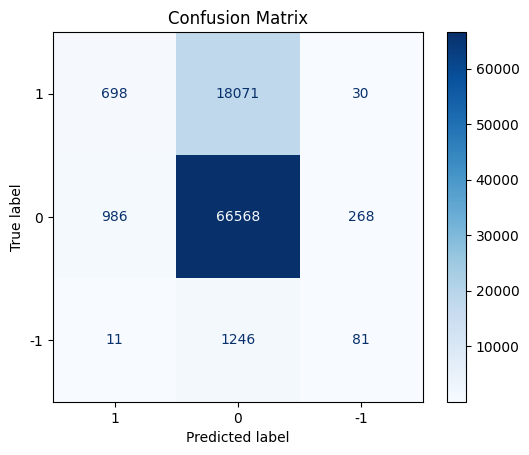

In [ ]:
# 혼동 행렬 계산
cm = confusion_matrix(df['actual_typeClass'], df['predicted_typeClass'], labels=[1, 0, -1])

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0, -1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# typeClass는 큰데, 리뷰 언급은 보통인 경우가 많아서 성능이 떨어짐

## goodsNo 기준으로 각각의 리뷰 값들을 합치고 리뷰 데이터 수만큼 나누기/typeClass도 마찬가지로 진행

In [ ]:
# goodsNo 기준으로 방향값들의 합을 구함('b_s_sum_df'로 지정)
columns_to_add = ['length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s']
b_s_sum_df = df.groupby('goodsNo')[columns_to_add].sum().reset_index()

In [ ]:
# goodsNo별 개수 계산
goodsNo_counts = df['goodsNo'].value_counts().reset_index()
goodsNo_counts.columns = ['goodsNo', 'sum_review']

# test_sum_df와 goodsNo_counts를 병합
b_s_sum_df = pd.merge(b_s_sum_df, goodsNo_counts, on='goodsNo', how='left')

In [ ]:
# 각 컬럼을 sum_review로 나누기
columns_to_divide = ['length_b_s', 'shoulder_b_s', 'chest_b_s', 'sleeve_b_s']
for column in columns_to_divide:
    b_s_sum_df[column] = b_s_sum_df[column] / b_s_sum_df['sum_review']

# sum_review 컬럼은 이제 필요없으므로 제거
b_s_sum_df.drop('sum_review', axis=1, inplace=True)

## 상품 별로 모든 사이즈값들을 묶어서 리스트 저장

In [ ]:
# size, length, shoulder, chest, sleeve 값을 리스트로 묶어서 각 goodsNo에 대해 중복값 제거 후 저장
def aggregate_features(group):
    unique_values = group.drop_duplicates(subset=['size', 'length', 'shoulder', 'chest', 'sleeve'])
    return unique_values[['size', 'length', 'shoulder', 'chest', 'sleeve']].values.tolist()

# groupby를 사용하여 goodsNo 기준으로 집계('size_total_df'로 지정)
size_total_df = df.groupby('goodsNo').apply(aggregate_features).reset_index(name='size_total')

## 상품 별 총장, 어깨, 가슴, 소매 값들의 gap 최빈값 확인

In [ ]:
# 차이를 계산하여 고유값을 얻는 함수 (최빈값을 구하기 위한 함수로 수정)
def calculate_mode(values):
    if len(values) == 0:
        return None
    freq = Counter(values)
    max_freq = max(freq.values())
    modes = [key for key, value in freq.items() if value == max_freq]
    return modes

# 차이를 계산하여 고유값을 얻는 함수 (차이값들을 구하고 최빈값을 찾아서 반환)
def calculate_unique_gaps(size_data, index):
    # index에 따른 값을 추출
    values = sorted([size[index] for size in size_data])
    gaps = [round(values[i+1] - values[i], 2) for i in range(len(values)-1)]
    unique_gaps = calculate_mode(gaps)
    return unique_gaps

# 새로운 컬럼을 추가하는 함수
def add_gap_columns(row):
    size_data = row['size_total']
    row['length_gap_mode'] = calculate_unique_gaps(size_data, 1)
    row['shoulder_gap_mode'] = calculate_unique_gaps(size_data, 2)
    row['chest_gap_mode'] = calculate_unique_gaps(size_data, 3)
    row['sleeve_gap_mode'] = calculate_unique_gaps(size_data, 4)
    return row

# 데이터프레임에 새로운 컬럼 추가('gap_mode_df'로 지정)
gap_mode_df = size_total_df.apply(add_gap_columns, axis=1)
gap_mode_df

In [ ]:
# 각 컬럼별로 null 값을 가진 행을 확인
null_indices = gap_mode_df[gap_mode_df['length_gap_mode'].isnull() |
                           gap_mode_df['shoulder_gap_mode'].isnull() |
                           gap_mode_df['chest_gap_mode'].isnull() |
                           gap_mode_df['sleeve_gap_mode'].isnull()].index

# null 값을 가지는 상품의 goodsNo 출력
products_with_null = gap_mode_df.loc[null_indices, 'goodsNo']

print("Null 값을 가지는 상품의 goodsNo:")
print(products_with_null)

## 수식 만들기
- length_gap_mode에서 최빈값을 구한 후 값이 2개 이상인 경우, 사분위수에 벗어나는 값을 제거한 후 상품별로 평균 내기

In [ ]:
# 추후에 사분위수 계산을 위해 작성
# 차이를 계산하여 고유값을 얻는 함수(round사용 이유:부동소수점 연산의 한계로 숫자가 이상하게 나옴)
def calculate_unique_gaps(size_data, index):
    # index에 따른 값을 추출 (length: 1, shoulder: 2, chest: 3, sleeve: 4)
    values = sorted([size[index] for size in size_data])
    gaps = [round(values[i+1] - values[i], 2) for i in range(len(values)-1)]
    unique_gaps = sorted(set(gaps))
    return unique_gaps

# 새로운 컬럼을 추가하는 함수
def add_gap_columns(row):
    size_data = row['size_total']
    row['length_gap'] = calculate_unique_gaps(size_data, 1)
    row['shoulder_gap'] = calculate_unique_gaps(size_data, 2)
    row['chest_gap'] = calculate_unique_gaps(size_data, 3)
    row['sleeve_gap'] = calculate_unique_gaps(size_data, 4)
    return row

# 데이터프레임에 새로운 컬럼 추가('gap_all_df'로 지정)
gap_all_df = size_total_df.apply(add_gap_columns, axis=1)

In [ ]:
# gap 컬럼들을 리스트로 저장
gap_columns = ['length_gap', 'shoulder_gap', 'chest_gap', 'sleeve_gap']

plt.figure(figsize=(15, 5))

# 각 gap 컬럼에 대해 박스플롯 그리기
for i, column in enumerate(gap_columns, start=1):
    plt.subplot(1, len(gap_columns), i)
    gaps = []
    for vals in gap_all_df[column]:
        gaps.extend(vals)

    # 박스플롯 그리기
    plt.boxplot(gaps)
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.title(f'Boxplot of {column}')
    plt.grid(True)

    # 사분위수 계산
    q1 = np.percentile(gaps, 25)
    q3 = np.percentile(gaps, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # outliers 계산
    small_outliers = [x for x in gaps if x < lower_bound ]
    big_outliers = [x for x in gaps if x > upper_bound]
    num_small_outliers = len(small_outliers)
    num_big_outliers = len(big_outliers)

    # 사분위수와 outliers 개수 출력
    print(f'{column} - Q1: {q1}, Q3: {q3}, IQR: {iqr}')
    print(f'{column} - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')
    print(f'{column} - Number of Small Outliers: {num_small_outliers}')
    print(f'{column} - Number of Big Outliers: {num_big_outliers}')

plt.tight_layout()
plt.show()

In [ ]:
# 사분위수 계산 함수
def calculate_quartiles(values):
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

# 최빈값 계산 함수
def calculate_mode(values):
    if len(values) == 0:
        return None
    freq = Counter(values)
    max_freq = max(freq.values())
    modes = [key for key, value in freq.items() if value == max_freq]
    return modes

# 각 gap의 고유값과 gap들을 계산하는 함수
def calculate_unique_gaps(size_data, index):
    values = sorted([size[index] for size in size_data])
    gaps = [round(values[i+1] - values[i], 2) for i in range(len(values)-1)]
    unique_gaps = calculate_mode(gaps)
    return unique_gaps, gaps

# 각 상품별로 gap을 계산하고 평균을 내는 함수
def add_gap_columns(row, lower_bounds, upper_bounds):
    size_data = row['size_total']

    length_mode, length_gaps = calculate_unique_gaps(size_data, 1)
    shoulder_mode, shoulder_gaps = calculate_unique_gaps(size_data, 2)
    chest_mode, chest_gaps = calculate_unique_gaps(size_data, 3)
    sleeve_mode, sleeve_gaps = calculate_unique_gaps(size_data, 4)

    if len(length_mode) > 1:
        filtered_length_gaps = [gap for gap in length_gaps if lower_bounds[0] <= gap <= upper_bounds[0]]
        length_mode = calculate_mode(filtered_length_gaps)

    if len(shoulder_mode) > 1:
        filtered_shoulder_gaps = [gap for gap in shoulder_gaps if lower_bounds[1] <= gap <= upper_bounds[1]]
        shoulder_mode = calculate_mode(filtered_shoulder_gaps)

    if len(chest_mode) > 1:
        filtered_chest_gaps = [gap for gap in chest_gaps if lower_bounds[2] <= gap <= upper_bounds[2]]
        chest_mode = calculate_mode(filtered_chest_gaps)

    if len(sleeve_mode) > 1:
        filtered_sleeve_gaps = [gap for gap in sleeve_gaps if lower_bounds[3] <= gap <= upper_bounds[3]]
        sleeve_mode = calculate_mode(filtered_sleeve_gaps)

    # 평균값 계산 후 소수점 둘째 자리까지 반올림
    row['length_gap_mode'] = round(np.mean(length_mode), 2) if length_mode else None
    row['shoulder_gap_mode'] = round(np.mean(shoulder_mode), 2) if shoulder_mode else None
    row['chest_gap_mode'] = round(np.mean(chest_mode), 2) if chest_mode else None
    row['sleeve_gap_mode'] = round(np.mean(sleeve_mode), 2) if sleeve_mode else None

    return row

# 각 gap 컬럼에 대해 사분위수 계산
gap_columns = ['length_gap', 'shoulder_gap', 'chest_gap', 'sleeve_gap']
lower_bounds = []
upper_bounds = []

for column in gap_columns:
    all_gaps = []
    for vals in gap_all_df[column]:
        all_gaps.extend(vals)
    lower_bound, upper_bound = calculate_quartiles(all_gaps)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)

# 데이터프레임에 새로운 컬럼 추가('gap_mode_not_outlier_df'로 지정)
gap_mode_not_outlier_df = size_total_df.apply(lambda row: add_gap_columns(row, lower_bounds, upper_bounds), axis=1)

# 사이즈 재구성을 위한 df('cal_df'로 지정)
cal_new_size_df = pd.merge(gap_mode_not_outlier_df, b_s_sum_df, on='goodsNo', how='inner')

In [ ]:
# 새로운 컬럼을 추가하는 함수 정의
def calculate_new_size_total(row):
    size_total = row['size_total']
    length_gap_mode = row['length_gap_mode']
    shoulder_gap_mode = row['shoulder_gap_mode']
    chest_gap_mode = row['chest_gap_mode']
    sleeve_gap_mode = row['sleeve_gap_mode']
    length_b_s = row['length_b_s']
    shoulder_b_s = row['shoulder_b_s']
    chest_b_s = row['chest_b_s']
    sleeve_b_s = row['sleeve_b_s']

    # 각 리스트 안의 리스트들에 대해 계산
    new_size_total = []
    for size in size_total:
        size_label = size[0]  # 첫 번째 값은 사이즈 레이블
        length = size[1] + (length_gap_mode * length_b_s) if len(size) > 1 else size[1]
        shoulder = size[2] + (shoulder_gap_mode * shoulder_b_s) if len(size) > 2 else size[2]
        chest = size[3] + (chest_gap_mode * chest_b_s) if len(size) > 3 else size[3]
        sleeve = size[4] + (sleeve_gap_mode * sleeve_b_s) if len(size) > 4 else size[4]
        new_size = [size_label, length, shoulder, chest, sleeve]
        new_size_total.append(new_size)

    # 새로운 컬럼에 할당
    row['size_new_total'] = new_size_total
    return row

# apply 함수를 사용하여 새로운 컬럼 추가('new_size_df'지정)
new_size_df = cal_new_size_df.apply(calculate_new_size_total, axis=1)

## new_size_df에서 'size_new_total'을 기존 df에 적용(새로 재구성된 사이즈 컬럼 추가)

In [ ]:
# 새로운 컬럼을 추가할 데이터프레임 생성('size_check'는 테스트용/추후에 drop가능)
df['size_check'] = None
df['length_new'] = None
df['shoulder_new'] = None
df['chest_new'] = None
df['sleeve_new'] = None

# 'goodsNo'와 'size' 정보가 일치하는 경우 해당 값을 새로운 컬럼에 추가
for i, row in df.iterrows():
    goods_no_match = row['goodsNo']
    size_match = row['size']
    size_total_cal_list = new_size_df[new_size_df['goodsNo'] == goods_no_match]['size_new_total'].values
    if len(size_total_cal_list) > 0:
        size_total_cal = size_total_cal_list[0]
        for sizes in size_total_cal:
            if sizes[0] == size_match:
                df.at[i, 'size_check'] = sizes[0]
                df.at[i, 'length_new'] = sizes[1]
                df.at[i, 'shoulder_new'] = sizes[2]
                df.at[i, 'chest_new'] = sizes[3]
                df.at[i, 'sleeve_new'] = sizes[4]
                break